## Financial news categorization/sentiment analysis using NLP techniques


Sentiment analysis is the statistical analysis of simple sentiment
cues. Essentially, it involves making statistical analyses on polarized
statements (i.e., statements with a positive, negative and neutral sentiment), which are usually collected in the form of social media posts,
reviews, and news articles. Financial sentiment analysis is a challenging task due to the specialized language and lack of labeled data in that domain.


In our case, we will focus on two different tasks.


1. **Category tagger**: Create a NLP classifier capable of assigning a financial category to a text derived from the financial industry.

The Twitter Financial News dataset is an English-language dataset containing an annotated corpus of finance-related tweets. This dataset is used to classify finance-related tweets for their topic.

    The dataset holds 21,107 documents annotated with 20 labels:

```json
topics = {
    "LABEL_0": "Analyst Update",
    "LABEL_1": "Fed | Central Banks",
    "LABEL_2": "Company | Product News",
    "LABEL_3": "Treasuries | Corporate Debt",
    "LABEL_4": "Dividend",
    "LABEL_5": "Earnings",
    "LABEL_6": "Energy | Oil",
    "LABEL_7": "Financials",
    "LABEL_8": "Currencies",
    "LABEL_9": "General News | Opinion",
    "LABEL_10": "Gold | Metals | Materials",
    "LABEL_11": "IPO",
    "LABEL_12": "Legal | Regulation",
    "LABEL_13": "M&A | Investments",
    "LABEL_14": "Macro",
    "LABEL_15": "Markets",
    "LABEL_16": "Politics",
    "LABEL_17": "Personnel Change",
    "LABEL_18": "Stock Commentary",
    "LABEL_19": "Stock Movement"
}
```

2. **Sentiment tagger**: Create a NLP classifier capable of assigning a sentiment score (positive,negative,neutral) to text derived from the financial industry. Additionally, we will use a powerful pre-trained model, finetuned on financial data, to assign scores to financial headlines, data from social media posts, etc ...


## Pre-requisites:


High level requirements of Python library.

    - Pytorch
    - HuggingFace Transformers library
    - Pandas
    - Numpy
    - Sklearn
    

In [1]:
# conda create --name finsent-env python=3.11  
# conda activate finset-env
# conda install pip
# !pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
# !pip install transformers
# !pip install pandas
# !pip install numpy
# !pip install -U scikit-learn

In [2]:
# Imports
import pickle
import torch
import time
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from transformers import \
    AutoModelForSequenceClassification, AutoTokenizer, \
    BertForSequenceClassification, BertTokenizer, BertForSequenceClassification, \
    AdamW, BertConfig, get_linear_schedule_with_warmup
from torch.utils.data import TensorDataset, random_split, DataLoader, RandomSampler, SequentialSampler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import CountVectorizer

%matplotlib inline

## **Step 1: Pulling the data together**


Download and inspect the data from the various sources:

1. Financial Phrasebank https://huggingface.co/datasets/financial_phrasebank. Humanly annotated - sentiment

2. Financial tweets topics dataset: https://huggingface.co/datasets/zeroshot/twitter-financial-news-topic/viewer/default/train?p=169. Humanly annotated - Category

Think of any pre-processing functions (
    Converting the text to lowercase,
    removing punctuation,
    tokenizing the text,
    removing stop words and empty strings,
    lemmatizing tokens.
) that you might need to apply for downstream tasks. As always, pick a framework for data analysis and data exploration.

In [3]:
# Loading sentences
sentences_50 = "../data/raw/Financial-Phrases-Sentiments/Sentences_50Agree.txt"
sentences_66 = "../data/raw/Financial-Phrases-Sentiments/Sentences_66Agree.txt"
sentences_75 = "../data/raw/Financial-Phrases-Sentiments/Sentences_75Agree.txt"
sentences_All= "../data/raw/Financial-Phrases-Sentiments/Sentences_AllAgree.txt"

# Saving in variable
files=[sentences_50, sentences_66, sentences_75, sentences_All]

# Function to get file data
def get_file_data(file):

    df = pd.read_csv(file, sep="@", encoding="iso-8859-1", header=None)
    df = df.rename(columns={0: 'Sentences', 1: 'Sentiment'})

    return df

In [4]:
df = get_file_data(sentences_All)
df.head()

,Sentences,Sentiment
0,"According to Gran , the company has no plans t...",neutral
1,"For the last quarter of 2010 , Componenta 's n...",positive
2,"In the third quarter of 2010 , net sales incre...",positive
3,Operating profit rose to EUR 13.1 mn from EUR ...,positive
4,"Operating profit totalled EUR 21.1 mn , up fro...",positive


**Explanatory Analysis**
1. **Sentiment Tagger** - 4 csv files containing finance headlines and sentiment labels (Positive, Neutral and Negative)

In [5]:
# Empty list to collect data
data = []

# Reading files
for file in files:

    # Read file data
    df = get_file_data(file)
    
    # Collect data for each file
    file_data = {
        'File': file.split('/')[-1],
        'Number of NaN values': df.isna().sum().sum(),  # Total NaN values across all columns
        'Number of records': df['Sentiment'].count()
    }
    
    # Number of occurrences for each sentiment
    sentiment_counts = df['Sentiment'].value_counts().to_dict()
    for sentiment, count in sentiment_counts.items():
        file_data[f'Occurrences - {sentiment}'] = count
    
    # Percentage of occurrences for each sentiment
    sentiment_percentages = df['Sentiment'].value_counts(normalize=True).to_dict()
    for sentiment, percentage in sentiment_percentages.items():
        file_data[f'Percentage - {sentiment}'] = round(percentage * 100, 2)
    
    # Append the data for this file to the list
    data.append(file_data)

# Convert the list of dictionaries to a DataFrame
summary_df = pd.DataFrame(data)

In [6]:
summary_df

,File,Number of NaN values,Number of records,Occurrences - neutral,Occurrences - positive,Occurrences - negative,Percentage - neutral,Percentage - positive,Percentage - negative
0,Sentences_50Agree.txt,0,4846,2879,1363,604,59.41,28.13,12.46
1,Sentences_66Agree.txt,0,4217,2535,1168,514,60.11,27.70,12.19
2,Sentences_75Agree.txt,0,3453,2146,887,420,62.15,25.69,12.16
3,Sentences_AllAgree.txt,0,2264,1391,570,303,61.44,25.18,13.38


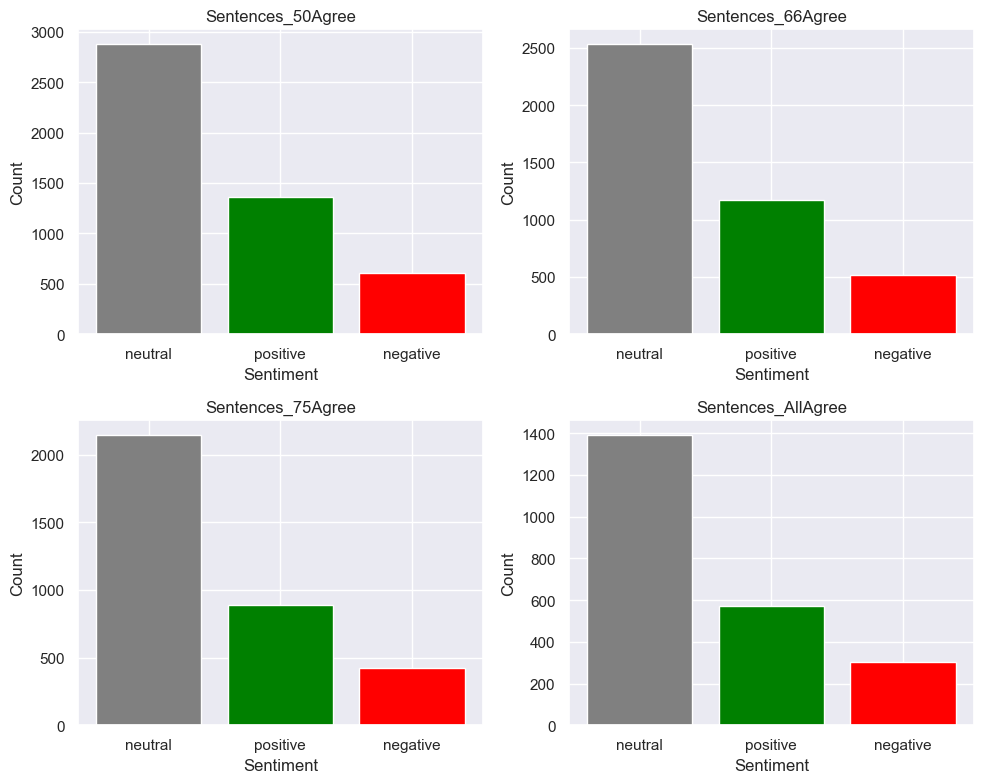

In [7]:
# Plot style
sns.set_theme()  # Applies the default Seaborn theme
sns.set_palette('pastel')  # Set the color palette

# Plot histograms for the 'Values' column in each DataFrame
fig, ax = plt.subplots(2, 2, figsize=(10, 8))

for i, file in enumerate(files):
    
    # Read file data
    df = get_file_data(file)

    # Find the index of the sequence in the sentence
    start_index = file.find("Sentences")
    end_index = file.find(".txt")
    
    if start_index != -1:  # If the sequence is found in the sentence
        # Extract the substring from the index of the sequence
        extracted_title = file[start_index:end_index]

    ax[i//2, i%2].bar(df['Sentiment'].value_counts().index, df['Sentiment'].value_counts(), color=['grey', 'green', 'red'])
    ax[i//2, i%2].set_title(extracted_title)
    ax[i//2, i%2].set_xlabel('Sentiment')
    ax[i//2, i%2].set_ylabel('Count')

    
plt.tight_layout()
plt.show()

**For the preprocessing step**, we will use the module CountVectorizer() from the python-library scikit-learn.

In [8]:
def vectorize_df(df):
    """ Vectorizer function """
    # Vectorizing the sentences
    vectorizer = CountVectorizer()

    X = vectorizer.fit_transform(df.iloc[:,0])
    y = df.iloc[:,1]

    return X, y, vectorizer

## **Step 2: Train and fine-tune various NLP classifiers on financial news datasets** 

#### **2.1 Let´s start with simple baseline (at your own choice)**. For example, build a logistic regression model based on pre-trained word embeddings or TF-IDF vectors of the financial news corpus.


Build a baseline model  with **Financial Phrasebank dataset**. What are the limitations of these baseline models?




---

In the financial sentence analysis plots, it's evident that we're dealing with an imbalanced dataset, where the `neutral` category dominates over `positive` and `negative` categories. To address this issue, and considering the complexities involved in gathering more data, or resampling, we'll adopt a simpler approach for our logistic regression base model. Specifically, we'll employ class weighting to rebalance the classes, using the `class_weight` parameter. This allows us to assign weights inversely proportional to class frequencies.

Moreover, beyond solely relying on accuracy, we'll explore additional metrics such as F1 score, precision-recall curves, AUC-ROC curves, and confusion matrices. These metrics offer a more comprehensive understanding of the model's performance, enabling us to make more informed decisions about its efficacy.

In [9]:
def create_baseline_model(X_train, y_train):
    """ Model creation fucntion (logistic regression)"""
    
    model = LogisticRegression(class_weight='balanced')
    model.fit(X_train, y_train)
    
    return model    

def predict_baseline_model(model, X_test, y_test):
    """ Model prediction function"""

    y_pred = model.predict(X_test)
    # Compute metrics
    class_report = classification_report(y_test, y_pred, output_dict=True)

    return y_pred, class_report

In [10]:
# Store the results
results = []
# Conncatenate dataframes
dfs = []

for file in files:
    
    file_name = file.split('/')[-1] # File namings
    df = get_file_data(file) # Read file data
    dfs.append(df) # For dataframe conncatenation
    X, y, vectorizer = vectorize_df(df) # Vectorize data

    # Train / Test splits
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
    # Baseline model and predictions
    bl_model = create_baseline_model(X_train, y_train)
    bl_model_pred, class_report = predict_baseline_model(bl_model, X_test, y_test)

    # Remove the 'accuracy' entry if it exists
    class_report.pop('accuracy', None)
    
    # Append the classification report to the results list
    for label, metrics in class_report.items():
        metrics['File'] = file_name
        metrics['Label'] = label
        results.append(metrics)

    # Save the vectorizer
    vects_path = f"../vectorizers/vectorizer_{file_name[10:-4]}.pkl"
    with open(vects_path, 'wb') as vect_file:
        pickle.dump(vectorizer, vect_file)
    
    models_path = f"../models/log-reg_mod_{file_name[10:-4]}.pkl"
    # Save the logistic regression model
    with open(models_path, 'wb') as mod_file:
        pickle.dump(bl_model, mod_file)

# Convert the list of dictionaries to a DataFrame
results_df = pd.DataFrame(results).set_index(['File', 'Label'])

In [11]:
results_df

precision    recall  f1-score  support
File                   Label                                               
Sentences_50Agree.txt  negative       0.648649  0.671329  0.659794    143.0
                       neutral        0.820194  0.831697  0.825905    713.0
                       positive       0.695015  0.665730  0.680057    356.0
                       macro avg      0.721286  0.722919  0.721919   1212.0
                       weighted avg   0.763185  0.764026  0.763467   1212.0
Sentences_66Agree.txt  negative       0.715517  0.653543  0.683128    127.0
                       neutral        0.846390  0.890145  0.867717    619.0
                       positive       0.770833  0.718447  0.743719    309.0
                       macro avg      0.777580  0.754045  0.764854   1055.0
                       weighted avg   0.808506  0.811374  0.809178   1055.0
Sentences_75Agree.txt  negative       0.750000  0.711340  0.730159     97.0
                       neutral        0.880218  0.915094  0.897317    530.0
                       positive       0.778281  0.725738  0.751092    237.0
                       macro avg      0.802833  0.784058  0.792856    864.0
                       weighted avg   0.837636  0.840278  0.838440    864.0
Sentences_AllAgree.txt negative       0.728395  0.776316  0.751592     76.0
                       neutral        0.924638  0.935484  0.930029    341.0
                       positive       0.835714  0.785235  0.809689    149.0
                       macro avg      0.829582  0.832345  0.830437    566.0
                       weighted avg   0.874878  0.874558  0.874390    566.0

To test the model with new data, we can use the following function.

In [12]:
def predict_sentiment(input_text, vectorizer, model):
    """
    Predicts the sentiment of the input text using the provided vectorizer and logistic regression model.

    Parameters:
        input_text: str, the text for which the sentiment needs to be predicted.
        vectorizer: CountVectorizer, the vectorizer that was fitted on the training data.
        model: LogisticRegression, the trained logistic regression model.

    Returns:
        str, the predicted sentiment label for the input text.
    """
    # Vectorize the input text using the fitted CountVectorizer
    input_text_vectorized = vectorizer.transform(input_text)

    # Predict the sentiment using the trained Logistic Regression model
    sentiment_prediction = model.predict(input_text_vectorized)

    return sentiment_prediction[0]  # Return the predicted sentiment label

New text example

In [13]:
input_text = "For the last quarter of 2010 , Componenta 's net sales drop to EUR76m from EUR167m for the same period a year earlier"

# Load model
model_path = "../models/log-reg_mod_AllAgree.pkl"
with open(model_path, 'rb') as mod_file:
    load_model = pickle.load(mod_file)

# Load vectorizer
vectorizer_path = "../vectorizers/vectorizer_AllAgree.pkl"
with open(vectorizer_path, 'rb') as vec_file:
    load_vectorizer = pickle.load(vec_file)

# Transform the new text using the loaded vectorizer
new_text_vectorized = load_vectorizer.transform([input_text])

# Predict the sentiment using the loaded model
predicted_sentiment = load_model.predict(new_text_vectorized)

print(f"Predicted Sentiment: {predicted_sentiment[0]}")

Predicted Sentiment: positive


It's apparent that the model is struggling to perform well with new data. This could be attributed primarily to either class imbalance or shortcomings in the training procedure. Moreover, it's worth noting that employing a model specifically tailored for sentences might not be ideal for handling the characteristics of the encountered new text data.

#### **2.2 Compare the baseline with a pre-trained model that is specialized for the finance domain. Download and use the FinBERT model from Huggingfaces**

Model source: https://huggingface.co/ProsusAI/finbert

Once you have downloaded the model, run inference and compute performance metrics to get a sense of how the specialized pre-trained model fares against the baseline  model.  Use the HuggingFaces library to download the model and run inference on it. For large datasets or text sequences, CPU running time might be large.

For more information on the model: Araci, D. (2019). FinBERT: Financial Sentiment Analysis with Pre-trained Language Models.

In [14]:
# Load the model and tokenizer
model_name = "ProsusAI/finbert"
model = AutoModelForSequenceClassification.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)

def sentiment_prediction(text, tokenizer, model):
    """ Sentiment prediction with BERT model"""
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=512)
    outputs = model(**inputs)
    probs = torch.nn.functional.softmax(outputs.logits, dim=-1)
    
    return torch.argmax(probs, dim=1).numpy()

# Mapping for evaluation
label_map = {0: 'positive', 1: 'negative', 2: 'neutral'}

In [15]:
# Save the BERT vectorizer
vects_path = "../vectorizers/small_FinBERT_vectorizer.pkl"
with open(vects_path, 'wb') as vect_file:
    pickle.dump(vectorizer, vect_file)
    
models_path = "../models/small_FinBERT_model.pkl"
# Save the BERT model
with open(models_path, 'wb') as mod_file:
    pickle.dump(model, mod_file)

In the following step, we will try the BERT model with the same data as the logistic regressor

In [16]:
all_sentences_df = get_file_data(sentences_All)

# Features (sentences) and target (Sentiment)
X = all_sentences_df['Sentences']
y = all_sentences_df['Sentiment']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)


In [17]:
# Predict sentiments for the training set
train_preds = [sentiment_prediction(text, tokenizer, model)[0] for text in X_train]

# Predict sentiments for the test set
test_preds = [sentiment_prediction(text, tokenizer, model)[0] for text in X_test]

# Apply the prediction function to text data
all_sentences_df['Predicted_Sentiment'] = all_sentences_df['Sentences'].apply(lambda x: sentiment_prediction([x], tokenizer, model))

In [18]:
all_sentences_df

,Sentences,Sentiment,Predicted_Sentiment
0,"According to Gran , the company has no plans t...",neutral,[2]
1,"For the last quarter of 2010 , Componenta 's n...",positive,[0]
2,"In the third quarter of 2010 , net sales incre...",positive,[0]
3,Operating profit rose to EUR 13.1 mn from EUR ...,positive,[0]
4,"Operating profit totalled EUR 21.1 mn , up fro...",positive,[0]
...,...,...,...
2259,Operating result for the 12-month period decre...,negative,[1]
2260,HELSINKI Thomson Financial - Shares in Cargote...,negative,[1]
2261,LONDON MarketWatch -- Share prices ended lower...,negative,[1]
2262,Operating profit fell to EUR 35.4 mn from EUR ...,negative,[1]


In [19]:
# Convert predictions to their corresponding sentiment labels
train_preds_labels = [label_map[pred] for pred in train_preds]
test_preds_labels = [label_map[pred] for pred in test_preds]

# Evaluate model performance on the training and test sets
print("Training Set Performance:")
print(classification_report(y_train, train_preds_labels))

print("Test Set Performance:")
print(classification_report(y_test, test_preds_labels))

Training Set Performance:
              precision    recall  f1-score   support

    negative       0.91      0.98      0.94       227
     neutral       1.00      0.96      0.98      1050
    positive       0.94      0.98      0.96       421

    accuracy                           0.97      1698
   macro avg       0.95      0.98      0.96      1698
weighted avg       0.97      0.97      0.97      1698

Test Set Performance:
              precision    recall  f1-score   support

    negative       0.89      0.99      0.94        76
     neutral       1.00      0.97      0.99       341
    positive       0.97      0.97      0.97       149

    accuracy                           0.98       566
   macro avg       0.95      0.98      0.96       566
weighted avg       0.98      0.98      0.98       566



Currently, we're conducting tests on a single dataframe. To broaden our analysis, we'll consolidate all dataframes using the variable `dfs` established earlier. After concatenating them, we'll address any duplicate entries and then iterate through the procedure once more to facilitate a comparative assessment of the results.

In [20]:
# Concatenate all dataframes into one
combined_df = pd.concat(dfs, ignore_index=True)

# Check for duplicated sentences
duplicates = combined_df.duplicated(subset=['Sentences'])

# Optional: Display duplicated sentences
print(combined_df[duplicates])

# Drop duplicates if needed
combined_df.drop_duplicates(subset=['Sentences'], inplace=True)

                                               Sentences Sentiment
79     TELECOMWORLDWIRE-7 April 2006-TJ Group Plc sel...  positive
789    The Group 's business is balanced by its broad...   neutral
1099   The issuer is solely responsible for the conte...   neutral
1416   The report profiles 614 companies including ma...   neutral
2396   Ahlstrom 's share is quoted on the NASDAQ OMX ...   neutral
...                                                  ...       ...
14775  Operating result for the 12-month period decre...  negative
14776  HELSINKI Thomson Financial - Shares in Cargote...  negative
14777  LONDON MarketWatch -- Share prices ended lower...  negative
14778  Operating profit fell to EUR 35.4 mn from EUR ...  negative
14779  Sales in Finland decreased by 10.5 % in Januar...  negative

[9942 rows x 2 columns]


In [21]:
# Features (sentences) and target (Sentiment)
X = combined_df['Sentences']
y = combined_df['Sentiment']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [22]:
# Predict sentiments for the training set
train_preds = [sentiment_prediction(text, tokenizer, model)[0] for text in X_train]

# Predict sentiments for the test set
test_preds = [sentiment_prediction(text, tokenizer, model)[0] for text in X_test]

# Apply the prediction function to text data
all_sentences_df['Predicted_Sentiment'] = all_sentences_df['Sentences'].apply(lambda x: sentiment_prediction([x], tokenizer, model))

In [23]:
# Convert predictions to their corresponding sentiment labels
train_preds_labels = [label_map[pred] for pred in train_preds]
test_preds_labels = [label_map[pred] for pred in test_preds]

# Evaluate model performance on the training and test sets
print("Training Set Performance:")
print(classification_report(y_train, train_preds_labels))

print("Test Set Performance:")
print(classification_report(y_test, test_preds_labels))

Training Set Performance:
              precision    recall  f1-score   support

    negative       0.80      0.97      0.88       448
     neutral       0.96      0.86      0.91      2160
    positive       0.81      0.92      0.86      1020

    accuracy                           0.89      3628
   macro avg       0.86      0.92      0.89      3628
weighted avg       0.90      0.89      0.89      3628

Test Set Performance:
              precision    recall  f1-score   support

    negative       0.80      0.96      0.87       156
     neutral       0.96      0.84      0.89       712
    positive       0.80      0.92      0.85       342

    accuracy                           0.88      1210
   macro avg       0.85      0.91      0.87      1210
weighted avg       0.89      0.88      0.88      1210



---

Up until now, we've utilized the BERT base model, comprising 12 layers of Transformer encoder, 12 attention heads, a hidden size of 768, and 110M parameters. Moving forward, we'll transition to employing the BERT large model, characterized by 24 layers of Transformer encoder, 16 attention heads, a hidden size of 1024, and 340 parameters.

This shift is motivated by our forthcoming utilization of extensive text data from {REDDIT - WHATEVER} to analyze the sentiment of financial text related to {BITCON - WHATEVER}. Given the complexity of this task, necessitating extensive NLP processing, we aim to fine-tune our approach. Here's how we plan to implement it:

- `[CLS]`: Serving as the initial token in every sequence, this denotes the classification token.

    For classification tasks, we must prepend the special `[CLS]` token to the beginning of every sentence.

    This token has special significance. BERT consists of 12 Transformer layers. Each transformer takes in a list of token embeddings, and produces the same number of embeddings on the output (but with the feature values changed, of course!).

- `[SEP]`: This special token demarcates to BERT which tokens belong to distinct sequences. While crucial for tasks like next sentence prediction or question-answering, if we're dealing with a single sequence, it's appended to its end.

    At the end of every sentence, we need to append the special `[SEP]` token. 

    This token is an artifact of two-sentence tasks, where BERT is given two separate sentences and asked to determine something (e.g., can the answer to the question in sentence A be found in sentence B?). 

BERT has two constraints:

- All sentences must be padded or truncated to a single, fixed length.
- The maximum sentence length is 512 tokens.
  
    It's worth noting that the maximum token input for BERT models is 512. If a sequence falls short, we can pad the unused slots with [PAD] tokens. Conversely, if a sequence exceeds 512 tokens, truncation is necessary.

    That's the entirety of what BERT expects for input. The BERT model then yields embedding vectors of size 768 for each token. These vectors serve as versatile inputs for various NLP applications, spanning text classification, next sentence prediction, Named-Entity-Recognition (NER), or question-answering tasks.

Padding is done with a special `[PAD]` token, which is at index 0 in the BERT vocabulary.

In [24]:
# Initialize the tokenizer and model with a pre-trained BERT model specifically fine-tuned for financial texts
tokenizer = BertTokenizer.from_pretrained('ProsusAI/finbert')
# Save the tokenizer
tok_path = "../tokenizers/large_FinBERT_tokenizer.pkl"
with open(tok_path, 'wb') as tok_file:
    pickle.dump(tokenizer, tok_file)

model = BertForSequenceClassification.from_pretrained('ProsusAI/finbert')
# Save the model
vects_path = "../models/large_FinBERT_model.pkl"
with open(vects_path, 'wb') as vect_file:
    pickle.dump(vectorizer, vect_file)

In [25]:
# Sample text to be tokenized and analyzed
txt = """
1. HIGHER LEVELS OF RETAIL PARTICIPATION IN CRYPTO THAN TRADITIONAL COMMODITY MARKETS POSE UNIQUE CHALLENGES FOR REGULATORS.

One in five Americans report having traded cryptocurrency, and polls suggest crypto trading is more common among younger adults, men, and racial minorities. This is quite different from other financial instruments regulated by the CFTC, Benham noted. “You’re going to have more vulnerable investors… It’s incumbent on us to educate, to inform, to disclose risks involved.”

Michael Piwowar, a former Securities and Exchange Commissioner and now executive director of the Milken Institute Center for Financial Markets, linked increased Congressional attention to growth in retail crypto: “If you got one in five households that have interacted with crypto… [members of Congress] are going to start hearing it from their constituents.” Legislation to regulate digital assets has been introduced by Senators Lummis and Gillibrand, Stabenow and Boozman, and Toomey, as well as Representative Gottheimer. The Treasury is actively negotiating bipartisan stablecoin legislation with House Financial Services Committee Chair Waters and Ranking Member McHenry. Benham said that stablecoins, digital currency meant to always be equal to one dollar, are more of a “payment mechanism” and thus should be regulated by prudential banking regulators.

Digital asset regulation may require addressing crypto exchanges and digital wallets. American University Law Professor Hilary Allen noted that the stablecoin legislation under discussion does not, saying, “That is a gaping hole… Almost every major stablecoin… is affiliated with an exchange that profits from trading in that stablecoin.” Mark Wetjen, a former CFTC commissioner and current head of policy and regulatory strategy for FTX (one of the largest crypto exchanges), agreed: “The exchanges are the gateways to the entire crypto space, and so oversight of them is probably most important.” He pushed back that there was no current regulation, noting the requirement for state level licenses, such as New York’s Bitlicense: “If you want to list derivatives on bitcoin, for example, you need a license… so it may not be as dire a situation.”

2. CRYPTO CHALLENGES TRADITIONAL REGULATORY DISTINCTION BETWEEN SECURITIES AND COMMODITIES.

Traditionally, the SEC regulates securities while the CFTC regulates commodities and derivatives. Whether crypto is a security or commodity remains unclear, as various subcomponents of the crypto ecosystem challenge existing regulatory divisions. For instance, the SEC recently argued  that nine different crypto tokens were securities in an insider trading case while a federal judge ruled that virtual currency like Bitcoin constitutes a commodity.

Benham called on Congress to provide clarity on which of the hundreds – if not thousands – of coins in existence are securities versus commodities: “Ultimately, we’d like to see law drawing lines.” Piwowar said the lack of clarity creates unwelcome delays as many crypto-related applications before the SEC are “not getting answers” on whether their products represent securities. The result is that some crypto firms are “going outside the United States” to locate their business. Allen cautioned, though, that Congressional action could also constitute an indication that the government supports crypto. She warned against letting crypto into the regulated sphere for fear of giving it “implicit guarantees.”

A solution to the regulatory turf battle could be merging the SEC and CFTC, which Piwowar endorsed, as have many others. Congress, however, has shown little appetite to do so given the different Congressional committee jurisdictions involved.

3. CFTC WILL RESTRUCTURE TO BETTER PROTECT CONSUMERS AND MORE EFFECTIVELY REGULATE MARKETS.
Benham announced several changes at the CFTC during the Brookings event. First, LabCFTC will become the Office of Technology Innovation, reporting directly to the Chairman’s office. Behnam justified this by stating, “We are past the incubator stage, and digital assets and decentralized financial technologies have outgrown their sandboxes.” Second, CFTC’s Office of Customer Education and Outreach will be realigned within the Office of Public Affairs, which Behnam said would “leverage resources and a broader understanding of the issues facing the general public towards addressing the most critical needs in the most vulnerable communities.” Restructuring within a regulator may appear a bureaucratic shuffle but can reflect changes in internal power, agency focus, and prioritization. Directly reporting to the chair increases an office’s authority and prestige.

4. IS CRYPTO A PASSING FAD (OR WORSE, A BUBBLE THAT THREATENS FINANCIAL MARKETS)?
Allen argued that crypto is “purposely less efficient and more complicated than a more centralized system,” and does not have any societal value. FTX’s Wetjen disagreed: “The difference here with blockchain as the underpinning means by which you can transfer value is that there are absolutely no gates.” Piwowar broadly agreed with Wetjen that “We’re going to have the new generation of Amazons and Googles come out of this stuff,” but cautioned that while he was at the SEC, “Nine out of ten [crypto applications] were outright fraud, and then out of the one out of ten, nine out of ten of those were probably fraud.” Since January 2021, over 46,000 people have collectively lost over $1 billion to scams involving crypto.

Everyone wants to avoid a repeat of the 2008 global financial crisis. To do so, regulators have focused on avoiding and mitigating “systemic risk” to the financial system. Asked if he sees a “clear and present danger to the existing economic system,” Benham said he did not, pointing out that crypto is not sufficiently interconnected to pose systemic risk. He noted the decrease in crypto values over the past several months did not cause ripples in the financial system or the broader economy. Piwowar turned the question of systemic risk back onto the actions of financial regulators asking: “What is systemic risk?  It’s the risk that a federal policymaker is going to bail out a bank, either directly or indirectly.” Allen agreed that bailing out crypto would be a mistake quipping: “If anything should be able to fail, it should be crypto, which isn’t… funding productive economic capacity.”

Allen also noted the similarity in arguments centered on American global competitiveness which promoted lax regulation for derivatives: “It’s almost identical to the rhetoric we saw around swaps in the 1990s.” Credit default swaps, like crypto now, faced loose regulation and ultimately helped fuel the subprime mortgage crisis. Behnam noted that one of 2008’s biggest lessons was the need for the CFTC to promote market transparency in the “OTC [over-the-counter] derivative space.” Crypto proponents point to the underlying technology as being inherently more transparent, while critics point to the lack of understanding of aspects of the market, such as what assets back stablecoins like Tether.

5. DOES CRYPTO INCREASE FINANCIAL INCLUSION?
Cryptocurrency proponents frequently cite financial inclusion as a major benefit linking the higher usage of youth and communities of color who have higher rates of being unbanked or underbanked by traditional finance. Allen cautioned against “predatory inclusion” arguing that, “Because there’s no productive capacity behind them, their value derives from finding someone else to buy them from you.” Wetjen’s responded, blending his experience serving as a CFTC Commissioner with his time in the crypto industry: “From my own experience… at the CFTC, there’s plenty of authority that’s already in place for the agency to… be pretty thoughtful and relatively prescriptive, even in terms of what actually should be disclosed to, particularly, retail investors, or users of a platform such as FTX.” He argued that the right policy is “giving people the opportunity to be involved and invest in the space that they like but making sure that it’s done with the right safeguards.”

"""

In this step, we'll undertake the required preprocessing to ensure that the model's input accepts a tensor-shaped format rather than a list of elements, as the latter could lead to errors.

In [26]:
# Tokenize the text, specifying not to add special tokens and to return PyTorch tensors
tokens = tokenizer.encode_plus(txt, add_special_tokens = False, return_tensors = 'pt')

# Print the number of keys in the tokenized output (input_ids, attention_mask, etc.)
print(tokens)
print(f"Number of keys in token dictionary: {len(tokens)}")
print(f"Sequence lenght: {len(tokens['input_ids'][0])}")

Token indices sequence length is longer than the specified maximum sequence length for this model (1653 > 512). Running this sequence through the model will result in indexing errors


{'input_ids': tensor([[1015, 1012, 3020,  ..., 2015, 1012, 1524]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 1, 1, 1]])}
Number of keys in token dictionary: 3
Sequence lenght: 1653


As we surpass the maximum sequence length for this model, we'll need to adopt the sliding window approach to accommodate the token length. For this, we will use the Pytorch capabilities to split in chunks of windows of 512.

Additionally, in this section we will be using the "Attention Mask" concept.

The "Attention Mask" is simply an array of 1s and 0s indicating which tokens are padding and which aren't (seems kind of redundant, doesn't it?!). This mask tells the "Self-Attention" mechanism in BERT not to incorporate these PAD tokens into its interpretation of the sentence.

The maximum length does impact training and evaluation speed, however. 
For example, with a Tesla K80 (GPU):

`MAX_LEN = 128  -->  Training epochs take ~5:28 each`

`MAX_LEN = 64   -->  Training epochs take ~2:57 each`

In [27]:
# Split the tokenized input_ids and attention_mask into chunks of size 510
input_id_chunks = tokens['input_ids'][0].split(510)
attention_mask_chunks = tokens['attention_mask'][0].split(510)

Checking on the lengths and shapes for inputs and chunks

In [28]:
# Print the length of the chunks list for both input_ids and attention_mask
print(f"Number of chunks: {len(attention_mask_chunks)}")
print(f"Size of the first chunk: {len(attention_mask_chunks[0])}")

# Check the shape of the first chunk of input_ids
print(f"Shape of the first input_id chunk {input_id_chunks[0].shape}")

Number of chunks: 4
Size of the first chunk: 510
Shape of the first input_id chunk torch.Size([510])


Before we are ready to encode our text, though, we need to decide on a maximum sentence length for padding / truncating to. In the following section, we will achieve this and go through the following steps my making use of the Pytorch capabilities:

    (1) Tokenize the sentence.
    (2) Prepend the `[CLS]` token to the start.
    (3) Append the `[SEP]` token to the end.
    (4) Map tokens to their IDs.
    (5) Pad or truncate the sentence to `max_length`
    (6) Create attention masks for [PAD] tokens.

In [29]:
def get_input_ids_and_attention_mask_chunk():
    """
    Splits the input_ids and attention_mask tensors into chunks, ensuring that each chunk, except possibly the last,
    has a length of `chunksize - 2` to accommodate for the addition of special tokens. Special tokens ([CLS] and [SEP])
    are prepended and appended to each chunk respectively. Chunks are padded with zeros to maintain uniform size.

    Returns:
        Tuple containing two lists of tensors, one for the chunked input_ids and the other for the chunked attention masks.
    """
    chunksize = 512
    # Split the tokens into chunks, leaving space for special tokens
    input_id_chunks = list(tokens['input_ids'][0].split(chunksize - 2))
    attention_mask_chunks = list(tokens['attention_mask'][0].split(chunksize - 2))
    
    # Iterate through each chunk to add special tokens and padding
    for i in range(len(input_id_chunks)):
        # Prepend [CLS] and append [SEP] tokens (101 and 102 respectively)
        input_id_chunks[i] = torch.cat([
            torch.tensor([101]), input_id_chunks[i], torch.tensor([102])
        ])
        # Prepend and append attention mask bits for special tokens
        attention_mask_chunks[i] = torch.cat([
            torch.tensor([1]), attention_mask_chunks[i], torch.tensor([1])
        ])

        # Calculate padding length
        pad_length = chunksize - input_id_chunks[i].shape[0]
        # Apply padding if necessary
        if pad_length > 0:
            input_id_chunks[i] = torch.cat([
                input_id_chunks[i], torch.Tensor([0] * pad_length)
            ])
            attention_mask_chunks[i] = torch.cat([
                attention_mask_chunks[i], torch.Tensor([0] * pad_length)
            ])
            
    return input_id_chunks, attention_mask_chunks 

In [30]:
# Get the processed chunks for input_ids and attention_mask
input_id_chunks, attention_mask_chunks = get_input_ids_and_attention_mask_chunk()

In this step, we'll combine the individual tensors for `input_ids` and `attention_mask`, stacking them to consolidate all tensor information into a single `input_dict` variable. This resulting tensor will serve as the input for the model.

In [31]:
# Stack the chunks to form tensors
input_ids = torch.stack(input_id_chunks)
attention_mask = torch.stack(attention_mask_chunks)

# Prepare the input dictionary for the model
input_dict = {
    'input_ids' : input_ids.long(),
    'attention_mask' : attention_mask.int()
}

print(input_dict)

{'input_ids': tensor([[  101,  1015,  1012,  ...,  1010,  1996,   102],
        [  101, 10819,  3728,  ...,  1521,  2128,   102],
        [  101,  2183,  2000,  ...,  2078,  1521,   102],
        [  101,  1055,  5838,  ...,     0,     0,     0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0]], dtype=torch.int32)}


In [32]:
# Check the shapes of the input tensors
print(input_dict['input_ids'].shape)
print(input_dict['attention_mask'].shape)

torch.Size([4, 512])
torch.Size([4, 512])


Wonderful, with the shape [4, 512], we can confidently affirm its compatibility with FinBert's requirements, considering the maximum token length (sequence length) of 512 and the specified number of batches, which is 4 in this scenario. Having verified this crucial step, we can proceed by invoking the model to obtain prediction outputs in the form of class probabilities using softmax layers.

In [33]:
# Pass the inputs through the model to get the outputs
outputs = model(**input_dict)

# Apply softmax to the logits to get probabilities
probabilities = torch.nn.functional.softmax(outputs[0], dim=-1)

# Compute the mean probabilities across all chunks
mean_probabilities = probabilities.mean(dim=0)

Subsequently, we'll map these probabilities to the respective "Positive", "Neutral", and "Negative" classes.

In [34]:
# Print the mean probabilities and the most likely class
print(f"Mean probabilities: {mean_probabilities}")

# Map the index to its corresponding label
predicted_class_index = torch.argmax(mean_probabilities).item()
print(f"Index of the highest probability class: {predicted_class_index}")
predicted_class_label = label_map[predicted_class_index]

# Print the predicted class label
print(f"Predicted class: {predicted_class_label}")

Mean probabilities: tensor([0.0767, 0.1188, 0.8045], grad_fn=<MeanBackward1>)
Index of the highest probability class: 2
Predicted class: neutral


#### **2.3 (Advanced) Fine-tune a pre-trained model such a base BERT model on a small labeled dataset**

General-purpose models are not effective enough because of the specialized language used in a financial context. We hypothesize that pre-trained language models can help with this problem because they require fewer labeled examples and they can be further trained on domain-specific corpora.

In recent years the NLP community has seen many breakthoughs in Natural Language Processing, especially the shift to transfer learning. Models like ELMo, fast.ai's ULMFiT, Transformer and OpenAI's GPT have allowed researchers to achieves state-of-the-art results on multiple benchmarks and provided the community with large pre-trained models with high performance. This shift in NLP is seen as NLP's ImageNet moment, a shift in computer vision a few year ago when lower layers of deep learning networks with million of parameters trained on a specific task can be reused and fine-tuned for other tasks, rather than training new networks from scratch.

One of the most significant milestones in the evolution of NLP recently is the release of Google's BERT, which is described as the beginning of a new era in NLP. In our case, we are going to explore a pre-trained model called FinBERT, already tuned with a financial corpus. I specifically recommend the HuggingFace library for easeness of implementation.

*What is HuggingFace?* Hugging Face’s Transformers is an open-source library that provides thousands of pre-trained models to perform various tasks on texts such as text classification, named entity recognition, translation, and more. The library has a unified, high-level API for these models and supports a wide range of languages and model architectures.


Here are various tutorials for finetuning BERT: https://drlee.io/fine-tuning-hugging-faces-bert-transformer-for-sentiment-analysis-69b976e6ac5d and https://skimai.com/fine-tuning-bert-for-sentiment-analysis/. I specially recommnend this one: http://mccormickml.com/2019/07/22/BERT-fine-tuning/

The dataset where to finetune a BERT related model can be found in the previous cell: **Financial tweets topics dataset** 

*ALERT*: Running or training a large language model like BERT or FinBERT might incur in large CPU processing times. Although BERT is very large, complicated, and have millions of parameters, we might only need to fine-tune it in only 2-4 epochs. You can also explore Google colab, for limited acces to free GPUs, which might best suited for this task., specially if training required.

Finally, compare the previous baseline with fine-tuned FinBERT

---

Based on the progress made thus far, for the fine tuning setp, we've opted to utilize a dataset sourced from the Hugging Face repositories. 

This dataset pertains to cryptocurrencies and Bitcoin, encompassing comments categorized as Positive, Negative, and Neutral. It can be accessed [here](https://huggingface.co/datasets/Andyrasika/alpaca-bitcoin-sentiment-dataset/viewer/default/train?p=1). Given the observed class imbalance within this dataset, we have chosen to supplement it by exclusively incorporating rows labeled as "Negative" from another dataset, available [here](https://huggingface.co/datasets/ckandemir/bitcoin_tweets_sentiment_kaggle/viewer/default/train?p=1).

Our focus during labeling has been to prioritize English sentences so the model can be optimized in this language with crypto currency and bitcoin argon.

# 1. Setup

## 1.1 Using Colab GPU for Training

For this fine-tuning phase, utilizing a GPU for training is highly recommended. Google Colab notebooks provide an excellent option as they offer free access to GPUs and TPUs. Given that we'll be training a large neural network, leveraging this resource is essential to expedite the process; otherwise, training duration could be significantly prolonged.

To attach a GPU, navigate to the menu and select:

`Edit 🡒 Notebook Settings 🡒 Hardware accelerator 🡒 (GPU)`

Afterward, execute the following cell to verify GPU detection.

In [35]:
# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

No GPU available, using the CPU instead.


# 2. Loading Alpaca Bitcoin Sentiment Dataset

As outr development, we will use and tune the model we have been using `BertForSequenceClassification.from_pretrained('ProsusAI/finbert')` with the enhanced [Andyrasika/alpaca-bitcoin-sentiment-dataset](https://huggingface.co/datasets/Andyrasika/alpaca-bitcoin-sentiment-dataset/viewer/default/train?f[output][value]=%27Neutral%27)

## 2.1 Load the Dataset

The merged dataset can be accesible in this project's repository

In [36]:
# Merged CSV file URL
csv_url = "https://raw.githubusercontent.com/pablo-git8/FinSentNewsNLP/main/data/raw/merged-bitcoin-sentiment.csv"

# Load the CSV file into a DataFrame
df = pd.read_csv(csv_url)

# Display the first few rows of the DataFrame
df.head()

,Date,text,Sentiment,language
0,2019-05-16,@Quark_Chain #QKC #Blockchain #BTC #ETH #block...,Negative,en
1,2019-07-11,"As of July 10, 2019 at 09:50AM, 1 BTC = 11671....",Negative,en
2,2019-07-01,https://t.co/utvdy6QR4r\nClick the link\nSign ...,Negative,en
3,2019-05-17,Bitcoin Price Correction Begins After a Massiv...,Negative,en
4,2016-12-18,#EuroCoin #EUC $0.000458 (44.80%) 0.00000058 B...,Negative,en


Next, we will define the sentences and labels variables

In [37]:
# Adjusting the mapping
inv_label_map = {'Positive': 0, 'Negative': 1, 'Neutral': 2}

# Get the lists of sentences and their labels.
sentences = df.text.values
labels = np.array([inv_label_map[label] for label in df.Sentiment.values])

Verifying label format for tensor conversion


In [38]:
np.unique(labels)

array([0, 1, 2])

## 3. Tokenization and Input Formatting

In this section, we'll transform our dataset into the format that BERT can be trained on

### 3.1 BERT Tokenizer

In [39]:
# Initialize the tokenizer and model with a pre-trained BERT model specifically fine-tuned for financial texts
print("Load the BERT tokenizer...")
tokenizer = BertTokenizer.from_pretrained('ProsusAI/finbert')

Load the BERT tokenizer...


Testing a random sentence

In [40]:
# Print the original sentence.
print(' Original: ', sentences[0])

# Print the sentence split into tokens.
print('Tokenized: ', tokenizer.tokenize(sentences[0]))

# Print the sentence mapped to token ids.
print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(sentences[0])))

 Original:  @Quark_Chain #QKC #Blockchain #BTC #ETH #blockchaintechnology #sharding
ыафвыв
ыв
аы
Tokenized:  ['@', 'qu', '##ark', '_', 'chain', '#', 'q', '##k', '##c', '#', 'block', '##chai', '##n', '#', 'bt', '##c', '#', 'et', '##h', '#', 'block', '##chai', '##nte', '##ch', '##nology', '#', 'sha', '##rdi', '##ng', 'ы', '##а', '##ф', '##в', '##ы', '##в', 'ы', '##в', 'а', '##ы']
Token IDs:  [1030, 24209, 17007, 1035, 4677, 1001, 1053, 2243, 2278, 1001, 3796, 24925, 2078, 1001, 18411, 2278, 1001, 3802, 2232, 1001, 3796, 24925, 10111, 2818, 21020, 1001, 21146, 17080, 3070, 1206, 10260, 29749, 25529, 29113, 25529, 1206, 25529, 1180, 29113]


### 3.2. Tokenize Dataset

In [41]:
max_len = 0

# For every sentence...
for sent in sentences:

    # Tokenize the text and add `[CLS]` and `[SEP]` tokens.
    input_ids = tokenizer.encode(sent, add_special_tokens=True)

    # Update the maximum sentence length.
    max_len = max(max_len, len(input_ids))

print('Max sentence length: ', max_len)

Max sentence length:  163


In [42]:
# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []

# For every sentence...
for sent in sentences:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 64,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.    
    input_ids.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

# Print sentence 0, now as a list of IDs.
print('Original: ', sentences[0])
print('Token IDs:', input_ids[0])

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
c:\Users\pablo\.conda\envs\finsent-env\Lib\site-packages\transformers\tokenization_utils_base.py:2619: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Original:  @Quark_Chain #QKC #Blockchain #BTC #ETH #blockchaintechnology #sharding
ыафвыв
ыв
аы
Token IDs: tensor([  101,  1030, 24209, 17007,  1035,  4677,  1001,  1053,  2243,  2278,
         1001,  3796, 24925,  2078,  1001, 18411,  2278,  1001,  3802,  2232,
         1001,  3796, 24925, 10111,  2818, 21020,  1001, 21146, 17080,  3070,
         1206, 10260, 29749, 25529, 29113, 25529,  1206, 25529,  1180, 29113,
          102,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0])


### 3.4. Training & Validation Split

Now that our input data is properly formatted, it's time to fine tune the BERT model.

In [43]:
# Combine the training inputs into a TensorDataset.
dataset = TensorDataset(input_ids, attention_masks, labels)

# Create a 90-10 train-validation split.

# Calculate the number of samples to include in each set.
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

# Divide the dataset by randomly selecting samples.
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

1,986 training samples
  221 validation samples


We'll also create an iterator for our dataset using the torch DataLoader class. This helps save on memory during training because, unlike a for loop, with an iterator the entire dataset does not need to be loaded into memory.

In [44]:
# The DataLoader needs to know our batch size for training, so we specify it 
# here. For fine-tuning BERT on a specific task, the authors recommend a batch 
# size of 16 or 32.
batch_size = 32

# Create the DataLoaders for our training and validation sets.
# We'll take training samples in random order. 
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

## 4. Train Our Classification Model

Now that our input data is properly formatted, it's time to fine tune the BERT model.

### 4.1. BertForSequenceClassification

For this task, we first want to modify the pre-trained BERT model to give outputs for classification, and then we want to continue training the model on our dataset until that the entire model, end-to-end, is well-suited for our task. 

Thankfully, the huggingface pytorch implementation includes a set of interfaces designed for a variety of NLP tasks. Though these interfaces are all built on top of a trained BERT model, each has different top layers and output types designed to accomodate their specific NLP task.  

Here is the current list of classes provided for fine-tuning:
* BertModel
* BertForPreTraining
* BertForMaskedLM
* BertForNextSentencePrediction
* **BertForSequenceClassification** - The one we'll use.
* BertForTokenClassification
* BertForQuestionAnswering

The documentation for these can be found under [here](https://huggingface.co/transformers/v2.2.0/model_doc/bert.html).

We'll be using [BertForSequenceClassification](https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#bertforsequenceclassification). This is the normal BERT model with an added single linear layer on top for classification that we will use as a sentence classifier. As we feed input data, the entire pre-trained BERT model and the additional untrained classification layer is trained on our specific task. 

OK, let's load BERT! There are a few different pre-trained BERT models available. "bert-base-uncased" means the version that has only lowercase letters ("uncased") and is the smaller version of the two ("base" vs "large").

The documentation for `from_pretrained` can be found [here](https://huggingface.co/transformers/v2.2.0/main_classes/model.html#transformers.PreTrainedModel.from_pretrained), with the additional parameters defined [here](https://huggingface.co/transformers/v2.2.0/main_classes/configuration.html#transformers.PretrainedConfig).

In [45]:
# Load BertForSequenceClassification, the pretrained BERT model with a single 
# linear classification layer on top. 
model = BertForSequenceClassification.from_pretrained(
    "ProsusAI/finbert", # Use the 12-layer BERT model, with an ProsusAI/finbert vocab.
    num_labels = 3, # The number of output labels--3 for multi classification. 
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)

# Tell pytorch to run this model on the GPU.
#model.cuda()

Just for curiosity's sake, we can browse all of the model's parameters by name here.

In the below cell, I've printed out the names and dimensions of the weights for:

1. The embedding layer.
2. The first of the twelve transformers.
3. The output layer.

In [46]:
# Get all of the model's parameters as a list of tuples.
params = list(model.named_parameters())

print('The BERT model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[5:21]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-4:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The BERT model has 201 different named parameters.

==== Embedding Layer ====

bert.embeddings.word_embeddings.weight                  (30522, 768)
bert.embeddings.position_embeddings.weight                (512, 768)
bert.embeddings.token_type_embeddings.weight                (2, 768)
bert.embeddings.LayerNorm.weight                              (768,)
bert.embeddings.LayerNorm.bias                                (768,)

==== First Transformer ====

bert.encoder.layer.0.attention.self.query.weight          (768, 768)
bert.encoder.layer.0.attention.self.query.bias                (768,)
bert.encoder.layer.0.attention.self.key.weight            (768, 768)
bert.encoder.layer.0.attention.self.key.bias                  (768,)
bert.encoder.layer.0.attention.self.value.weight          (768, 768)
bert.encoder.layer.0.attention.self.value.bias                (768,)
bert.encoder.layer.0.attention.output.dense.weight        (768, 768)
bert.encoder.layer.0.attention.output.dense.bias              (

### 4.1. Optimizer & Learning Rate Scheduler

Now that we have our model loaded we need to grab the training hyperparameters from within the stored model.

For the purposes of fine-tuning, the authors recommend choosing from the following values (from Appendix A.3 of the [BERT paper](https://arxiv.org/pdf/1810.04805.pdf)):

>- **Batch size:** 16, 32  
- **Learning rate (Adam):** 5e-5, 3e-5, 2e-5  
- **Number of epochs:** 2, 3, 4 

We chose:
* Batch size: 32 (set when creating our DataLoaders)
* Learning rate: 2e-5
* Epochs: 4 (we'll see that this is probably too many...)

The epsilon parameter `eps = 1e-8` is "a very small number to prevent any division by zero in the implementation" (from [here](https://machinelearningmastery.com/adam-optimization-algorithm-for-deep-learning/)).

You can find the creation of the AdamW optimizer in `run_glue.py` [here](https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L109).

In [47]:
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )

c:\Users\pablo\.conda\envs\finsent-env\Lib\site-packages\transformers\optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [48]:
# Number of training epochs. The BERT authors recommend between 2 and 4. 
# We chose to run for 4, but we'll see later that this may be over-fitting the
# training data.
epochs = 4

# Total number of training steps is [number of batches] x [number of epochs]. 
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

### 4.3 Training Loop

Below is our training loop. There's a lot going on, but fundamentally for each pass in our loop we have a trianing phase and a validation phase. 

> *Thank you to [Stas Bekman](https://ca.linkedin.com/in/stasbekman) for contributing the insights and code for using validation loss to detect over-fitting!*

**Training:**
- Unpack our data inputs and labels
- Load data onto the GPU for acceleration
- Clear out the gradients calculated in the previous pass. 
    - In pytorch the gradients accumulate by default (useful for things like RNNs) unless you explicitly clear them out.
- Forward pass (feed input data through the network)
- Backward pass (backpropagation)
- Tell the network to update parameters with optimizer.step()
- Track variables for monitoring progress

**Evalution:**
- Unpack our data inputs and labels
- Load data onto the GPU for acceleration
- Forward pass (feed input data through the network)
- Compute loss on our validation data and track variables for monitoring progress

Pytorch hides all of the detailed calculations from us, but we've commented the code to point out which of the above steps are happening on each line. 

> *PyTorch also has some [beginner tutorials](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#sphx-glr-beginner-blitz-cifar10-tutorial-py) which you may also find helpful.*

In [49]:
# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [50]:
def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

```python
# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128

# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# We'll store a number of quantities such as training and validation loss, 
# validation accuracy, and timings.
training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    # Put the model into training mode. Don't be mislead--the call to 
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the 
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because 
        # accumulating the gradients is "convenient while training RNNs". 
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch).
        # In PyTorch, calling `model` will in turn call the model's `forward` 
        # function and pass down the arguments. The `forward` function is 
        # documented here: 
        # https://huggingface.co/transformers/model_doc/bert.html#bertforsequenceclassification
        # The results are returned in a results object, documented here:
        # https://huggingface.co/transformers/main_classes/output.html#transformers.modeling_outputs.SequenceClassifierOutput
        # Specifically, we'll get the loss (because we provided labels) and the
        # "logits"--the model outputs prior to activation.
        result = model(b_input_ids, 
                       token_type_ids=None, 
                       attention_mask=b_input_mask, 
                       labels=b_labels,
                       return_dict=True)

        loss = result.loss
        logits = result.logits

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        total_train_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)            
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using 
        # the `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            # token_type_ids is the same as the "segment ids", which 
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            result = model(b_input_ids, 
                           token_type_ids=None, 
                           attention_mask=b_input_mask,
                           labels=b_labels,
                           return_dict=True)

        # Get the loss and "logits" output by the model. The "logits" are the 
        # output values prior to applying an activation function like the 
        # softmax.
        loss = result.loss
        logits = result.logits
            
        # Accumulate the validation loss.
        total_eval_loss += loss.item()

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
        total_eval_accuracy += flat_accuracy(logits, label_ids)
        

    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))
```

```python
# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# A hack to force the column headers to wrap.
#df = df.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])

# Display the table.
df_stats
```

Notice that, while the the training loss is going down with each epoch, the validation loss is increasing! This suggests that we are training our model too long, and it's over-fitting on the training data. 

Validation Loss is a more precise measure than accuracy, because with accuracy we don't care about the exact output value, but just which side of a threshold it falls on. 

If we are predicting the correct answer, but with less confidence, then validation loss will catch this, while accuracy will not.

```python
# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()
```

Saving the trained model

```python
# Saving best-practices: if you use defaults names for the model, you can reload it using from_pretrained()

output_dir = './model_save/'

# Create output directory if needed
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print("Saving model to %s" % output_dir)

# Save a trained model, configuration and tokenizer using `save_pretrained()`.
# They can then be reloaded using `from_pretrained()`
model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

# Good practice: save your training arguments together with the trained model
# torch.save(args, os.path.join(output_dir, 'training_args.bin'))
```

## **Step 3: Deployment of the sentiment/category tagger on  financial news or social media posts**

Let´s now turn our attention to a live deployment of the financial news tagger. Things can get quite complicated, specially if we add streaming data, so it is best to keep the deploymnet lightweight. There are mainly three important pieces. Let´s explore them:


- Build a local dashboard/app (e.g. using Streamlit or another web applications framework of your choice). A bit UI to display the sentiment tagger in action and demonstrate the practical application of your model.


- Build a financial news/alerts scraper pipeline, filter some entities if you focus your search. In a real world setting,  you’d likely want to build a more robust infrastructure for processing and ingestion of new examples, handling any preprocessing, and outputting predictions. Here are some options where to scrape data (real-time data might be expensive or limited):

    - <span style="color:blue">*Social Media Posts*</span>: Pulling historical or live data from tweets or reddit. There are public APIs with extensive documentation for them.
    - <span style="color:blue">*OpenBB*</span>: Open research investment platform. It aggregates financial news across the world and has an API to access them.
    - <span style="color:blue">*Financial news outlet*</span>: Yahoo Finance
    
An pipeline example: The basic premise is to read in a stream of tweets, use a lighweight sentiment analysis engine (BERT might not be a good fit here) to assign a bullish/neutral/bearish score to each tweet, and then see how this cumulatively changes over time.
    
    
- Build an inference endpoint for the tagging model. Within your infrastructure, you can deploy and load the resuting model. One way is to build a REST API endpoint, only to be queried locally (in your laptop).



**Extra:** You could explore or quantify correlations with the market for a list of selected stock.

# This work is included in the FinSentAPI development